# VLM-RAG Test Notebook

## System Components:
1. **Vector Database** - ChromaDB for storing past interactions
2. **Visual Interpreter** - OpenRouter API for vision models 
3. **Validation Judge** - LLM judge for comparing responses

## Research Questions:
1. To what degree do BLV users visual needs change across similar visual contexts?
2. Can we leverage past users interactions to provide more relevant future visual interpretations?


In [5]:
# Setup and imports
import chromadb
import pandas as pd
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import sys
import os
from dotenv import load_dotenv
load_dotenv()

# Add the parent directory to path so we can import our modules
sys.path.append('..')

# Now we can import from the src directory
from src.vector_db import SimpleVectorDB

# Step 1: Initialize the Vector Database
print("🚀 Initializing Vector Database for Image Embeddings...")

# Initialize the simplified vector database
db = SimpleVectorDB()

print("\n✅ Vector Database initialized!")

🚀 Initializing Vector Database for Image Embeddings...
Vector DB initialized at: ./data/chroma_db
Persistence enabled for pre-calculated embeddings.

✅ Vector Database initialized!


# Load Collection or Create a new One

In [3]:

print("🗄️ Creating fresh collection for this experiment...")

experiment_name = "vizwiz_experiment_v2"

# Create new database instance with fresh collection
db.use_collection("vizwiz_500_sample_cosine", "500 random VizWiz samples using cosine similarity")
# Check it's empty
stats = db.get_collection_stats()
print(f"📊 Fresh collection stats: {stats}")

print("✅ Fresh collection created for controlled experiment!")


🗄️ Creating fresh collection for this experiment...


InvalidArgumentError: Validation error: metadata: Metadata cannot be empty

# Load 500 entries from vizwiz

In [8]:
# Step 2: Load VizWiz data and generate random sample
import json
import random
import pandas as pd
from IPython.display import display
from pathlib import Path

print("📝 Loading VizWiz data and generating random sample...")

# Load the original JSON data
data_path = Path('./data/original/all.json')
try:
    with open(data_path, 'r') as f:
        all_data = json.load(f)
    print(f"✅ Loaded {len(all_data)} total entries from all.json")
except FileNotFoundError:
    print(f"❌ File '{data_path}' not found!")
    print("Please make sure you have the VizWiz data in the correct location.")
    all_data = {}

# Check if collection already has data
stats = db.get_collection_stats()
if stats.get("total_images", 0) > 0:
    print(f"📊 Found existing collection with {stats['total_images']} entries")
    
    # Get all IDs from the existing collection
    results = db.current_collection.get()
    existing_ids = results["ids"]
    print(f"🔄 Using {len(existing_ids)} existing IDs from collection")
    
    # Extract sample data from all_data using existing IDs
    sample_data = {}
    for key in existing_ids:
        if key in all_data:
            sample_data[key] = all_data[key]
    
    print(f"✅ Extracted {len(sample_data)} entries from existing collection")
else:
    # Generate 500 random IDs
    if all_data:
        # Get all available keys from the JSON
        available_keys = list(all_data.keys())
        print(f"Available keys range: {min(available_keys)} to {max(available_keys)}")
        
        # Generate 500 random keys (without replacement)
        sample_size = min(500, len(available_keys))
        random_keys = random.sample(available_keys, sample_size)
        
        print(f"🎲 Generated {len(random_keys)} random keys for sampling")
        print(f"Sample keys: {random_keys[:10]}...")  # Show first 10
        
        # Extract sample data
        sample_data = {}
        for key in random_keys:
            if key in all_data:
                sample_data[key] = all_data[key]
        
        print(f"✅ Extracted {len(sample_data)} entries for processing")
    else:
        sample_data = {}
        print("⚠️ No data loaded - will use dummy data for testing")

# Show example of what we extracted
if sample_data:
    example_key = list(sample_data.keys())[0]
    example_entry = sample_data[example_key]
    print(f"\n📋 Example entry (ID: {example_key}):")
    for field in ['question', 'answerability', 'question_type', 'crowd_majority', 'image_url']:
        if field in example_entry:
            print(f"  {field}: {example_entry[field]}")
    
    # Display first 10 rows as a table
    print("\n📊 First 10 sampled entries:")
    sample_rows = []
    for i, (key, data) in enumerate(list(sample_data.items())[:10]):
        sample_rows.append({
            'ID': key,
            'Question': data.get('question', 'N/A'),
            'Answerability': data.get('answerability', 'N/A'),
            'Question Type': data.get('question_type', 'N/A'),
            'Crowd Majority': data.get('crowd_majority', 'N/A'),
            'Image URL': data.get('image_url', 'N/A')
        })
    
    # Create and display DataFrame
    df = pd.DataFrame(sample_rows)
    display(df)


📝 Loading VizWiz data and generating random sample...
✅ Loaded 600 total entries from all.json
Available keys range: 1 to 99
🎲 Generated 500 random keys for sampling
Sample keys: ['435', '188', '388', '434', '456', '209', '489', '219', '228', '9']...
✅ Extracted 500 entries for processing

📋 Example entry (ID: 435):
  question: What page number is this? Thank you.
  answerability: unanswerable
  question_type: Reading
  crowd_majority: unanswerable
  image_url: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00019650.jpg

📊 First 10 sampled entries:


,ID,Question,Answerability,Question Type,Crowd Majority,Image URL
0,435,What page number is this? Thank you.,unanswerable,Reading,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
1,188,What color is this cartridge?,answerable,Description,magenta,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
2,388,What page is this? Thank you.,unanswerable,Reading,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
3,434,What does this cup say?,unanswerable,Reading,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
4,456,The way this guy was described to me was that ...,unanswerable,Others,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
5,209,Which color?,answerable,Description,yellow,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
6,489,Do you think my wife's decorating is any good ...,answerable,Others,yes,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
7,219,What's the color?,answerable,Description,peach,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
8,228,What color is this?,answerable,Description,grey,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...
9,9,What is it?,answerable,Identification,heavenly crisp candy bar,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...


# Check Collection Currently loaded

In [2]:
stats = db.get_collection_stats()
print(f"📊 Fresh collection stats: {stats}")

AttributeError: 'SimpleVectorDB' object has no attribute 'get_collection_stats'

In [46]:
# Check if embeddings file exists, if not generate embeddings
embeddings_file = "data/embeddings/lf_vqa_db_embeddings_cohere.json"

print(f"📂 Checking for embeddings file: {embeddings_file}")

if os.path.exists(embeddings_file):
    print(f"✅ Found existing embeddings file, loading...")
    
    try:
        with open(embeddings_file, 'r') as f:
            embeddings_data = json.load(f)
        
        print(f"✅ Loaded embeddings data:")
        print(f"  Collection name: {embeddings_data['collection_name']}")
        print(f"  Count: {embeddings_data['count']}")
        print(f"  Items loaded: {len(embeddings_data['items'])}")
        
        # Prepare data for ChromaDB insertion
        ids = []
        embeddings = []
        metadatas = []
        documents = []
        
        for item in embeddings_data['items']:
            item_id = item['id']
            embedding = item['embedding']
            metadata = item['metadata']  # Use metadata directly from the JSON structure
            
            # Extract the question for the document text
            document = metadata.get('question', f'Item {item_id}')
            
            ids.append(item_id)
            embeddings.append(embedding)
            metadatas.append(metadata)
            documents.append(document)
        
        # Add embeddings to ChromaDB collection
        print(f"🔄 Adding {len(ids)} embeddings to ChromaDB collection...")
        
        # Clear existing collection if it exists
        try:
            db.client.delete_collection(name="viswiz_500_sample_cosine")
            print("🗑️ Cleared existing collection")
        except:
            pass
        
        # Create new collection
        collection = db.client.create_collection(
            name="viswiz_500_sample_cosine",
            metadata={"description": "VizWiz VQA embeddings generated with Cohere"}
        )
        
        # Add embeddings in batches to avoid memory issues
        batch_size = 100
        for i in range(0, len(ids), batch_size):
            batch_ids = ids[i:i+batch_size]
            batch_embeddings = embeddings[i:i+batch_size]
            batch_metadatas = metadatas[i:i+batch_size]
            batch_documents = documents[i:i+batch_size]
            
            collection.add(
                ids=batch_ids,
                embeddings=batch_embeddings,
                metadatas=batch_metadatas,
                documents=batch_documents
            )
            print(f"  ✅ Added batch {i//batch_size + 1}/{(len(ids)-1)//batch_size + 1}")
        
        print(f"🎉 Successfully loaded {len(ids)} embeddings into ChromaDB!")
        
        # Update db to use the new collection
        db.collection_name = "viswiz_500_sample_cosine"
        db.collection = collection
        
    except Exception as e:
        print(f"❌ Error loading embeddings: {str(e)}")

else:
    print(f"⚠️ Embeddings file not found: {embeddings_file}")
    print("📝 Will generate embeddings for sample data...")
    
    if not sample_data:
        print("❌ No sample data available to generate embeddings from")
    else:
        print(f"🔄 Generating embeddings for {len(sample_data)} items...")
        
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(embeddings_file), exist_ok=True)
        
        # Initialize embeddings storage
        embeddings_to_save = {
            "collection_name": "viswiz_500_sample_cosine",
            "count": len(sample_data),
            "items": []
        }
        
        # Generate embeddings for each item (this will be implemented in the next cell)
        print("⏳ Embedding generation will be implemented in the next cells...")
        print("For now, creating empty collection to continue with the workflow...")
        
        # Create empty collection for now
        try:
            db.client.delete_collection(name="viswiz_500_sample_cosine")
            print("🗑️ Cleared existing collection")
        except:
            pass
        
        collection = db.client.create_collection(
            name="viswiz_500_sample_cosine",
            metadata={"description": "VizWiz VQA embeddings (to be generated)"}
        )
        
        # Update db to use the new collection
        db.collection_name = "viswiz_500_sample_cosine"
        db.collection = collection
        
        print("✅ Created empty collection - embeddings will be generated in subsequent cells")

📂 Checking for embeddings file: data/embeddings/lf_vqa_db_embeddings_cohere.json
✅ Found existing embeddings file, loading...
✅ Loaded embeddings data:
  Collection name: vizwiz_500_sample
  Count: 500
  Items loaded: 500
🔄 Adding 500 embeddings to ChromaDB collection...
🗑️ Cleared existing collection
  ✅ Added batch 1/5
  ✅ Added batch 2/5
  ✅ Added batch 3/5
  ✅ Added batch 4/5
  ✅ Added batch 5/5
🎉 Successfully loaded 500 embeddings into ChromaDB!


## Define embedding generation functions

# Image finder


🎲 Testing similarity search with random image ID: 257
🔍 Finding similar images to ID: 257
📋 Query image info:
  Question: What's the content of this screen?
  Question Type: Description
  Image URL: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00013131.jpg

🎯 Found 3 similar images:

  1. ID: 253
     Similarity Score: 0.2397
     Question: What color is this?
     Question Type: Description
     Image URL: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00008661.jpg

  2. ID: 446
     Similarity Score: 0.2358
     Question: I tried turning the bottle. Can you read what is on the bottle? I'm trying to figure out what medicine it is.
     Question Type: Reading
     Image URL: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00000347.jpg

  3. ID: 294
     Similarity Score: 0.2177
     Question: What color is this skirt please?  Thank you.
     Question Type: Description
     Image URL: https://vizwiz.cs.colorado.edu/VizW

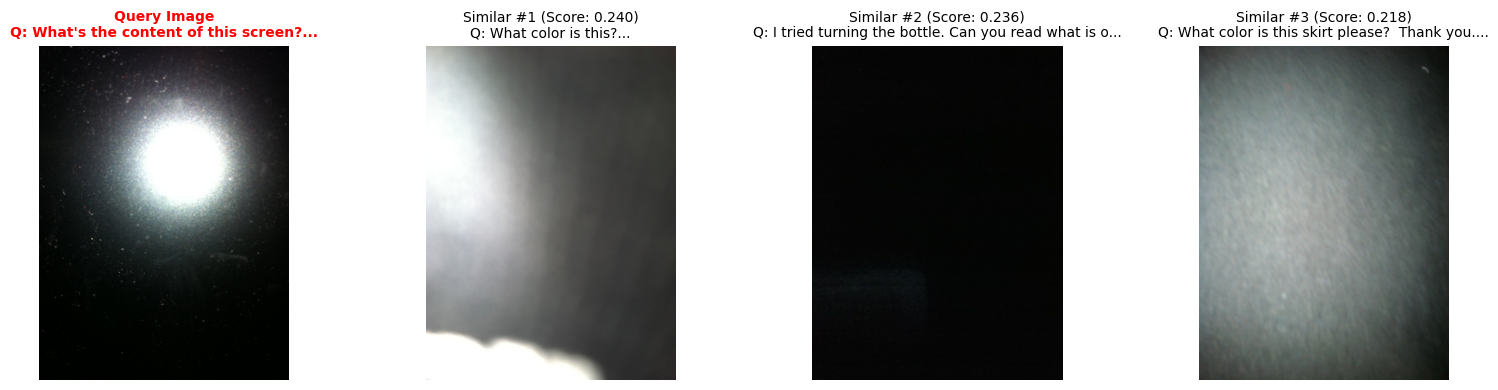


✅ Similarity search completed successfully!


In [50]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

def find_similar_images(image_id, n_results=3, plot_images=True):
    """
    Find the most similar images to a given image ID based on embeddings
    
    Args:
        image_id: The ID of the reference image
        n_results: Number of similar images to return (default: 3)
        plot_images: Whether to plot the query and similar images (default: True)
        
    Returns:
        Dictionary containing the query image info and similar images with their metadata
    """
    try:
        # First, get the embedding for the query image
        query_result = db.collection.get(ids=[image_id], include=['embeddings', 'metadatas'])
        
        if not query_result['ids']:
            print(f"❌ Image ID '{image_id}' not found in collection")
            return None
        
        query_embedding = query_result['embeddings'][0]
        query_metadata = query_result['metadatas'][0]
        
        print(f"🔍 Finding similar images to ID: {image_id}")
        print(f"📋 Query image info:")
        print(f"  Question: {query_metadata.get('question', 'N/A')}")
        print(f"  Question Type: {query_metadata.get('question_type', 'N/A')}")
        print(f"  Image URL: {query_metadata.get('image_url', 'N/A')}")
        
        # Search for similar images (excluding the query image itself)
        similar_results = db.collection.query(
            query_embeddings=[query_embedding],
            n_results=n_results + 1,  # +1 to account for the query image itself
            include=['metadatas', 'distances']
        )
        
        # Filter out the query image from results
        similar_images = []
        for i, (result_id, metadata, distance) in enumerate(zip(
            similar_results['ids'][0],
            similar_results['metadatas'][0], 
            similar_results['distances'][0]
        )):
            if result_id != image_id:  # Exclude the query image
                similar_images.append({
                    'id': result_id,
                    'metadata': metadata,
                    'distance': distance,
                    'similarity_score': 1 - distance  # Convert distance to similarity
                })
                
                if len(similar_images) >= n_results:
                    break
        
        print(f"\n🎯 Found {len(similar_images)} similar images:")
        for i, img in enumerate(similar_images, 1):
            print(f"\n  {i}. ID: {img['id']}")
            print(f"     Similarity Score: {img['similarity_score']:.4f}")
            print(f"     Question: {img['metadata'].get('question', 'N/A')}")
            print(f"     Question Type: {img['metadata'].get('question_type', 'N/A')}")
            print(f"     Image URL: {img['metadata'].get('image_url', 'N/A')}")
        
        # Plot images if requested
        if plot_images:
            plot_query_and_similar_images(query_metadata, similar_images)
        
        return {
            'query_image': {
                'id': image_id,
                'metadata': query_metadata
            },
            'similar_images': similar_images
        }
        
    except Exception as e:
        print(f"❌ Error finding similar images: {str(e)}")
        return None


def load_image_from_url(image_url):
    """
    Load an image from a URL
    
    Args:
        image_url: URL of the image to load
        
    Returns:
        PIL Image object or None if failed to load
    """
    try:
        response = requests.get(image_url, timeout=10)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        return image
    except Exception as e:
        print(f"⚠️ Failed to load image from {image_url}: {str(e)}")
        return None


def plot_query_and_similar_images(query_metadata, similar_images):
    """
    Plot the query image and its most similar images
    
    Args:
        query_metadata: Metadata dictionary for the query image
        similar_images: List of similar image dictionaries
    """
    try:
        # Calculate grid dimensions
        total_images = 1 + len(similar_images)  # query + similar images
        cols = min(4, total_images)  # Max 4 columns
        rows = (total_images + cols - 1) // cols  # Ceiling division
        
        # Create figure and subplots
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        
        # Handle case where we have only one row
        if rows == 1:
            axes = [axes] if total_images == 1 else axes
        else:
            axes = axes.flatten()
        
        # Plot query image
        query_image_url = query_metadata.get('image_url')
        if query_image_url:
            query_image = load_image_from_url(query_image_url)
            if query_image:
                axes[0].imshow(query_image)
                axes[0].set_title(f"Query Image\nQ: {query_metadata.get('question', 'N/A')[:50]}...", 
                                fontsize=10, fontweight='bold', color='red')
                axes[0].axis('off')
            else:
                axes[0].text(0.5, 0.5, 'Failed to\nload image', ha='center', va='center', 
                           transform=axes[0].transAxes, fontsize=12)
                axes[0].set_title("Query Image (Failed to Load)", fontsize=10, color='red')
                axes[0].axis('off')
        
        # Plot similar images
        for i, img_data in enumerate(similar_images):
            ax_idx = i + 1
            if ax_idx >= len(axes):
                break
                
            image_url = img_data['metadata'].get('image_url')
            if image_url:
                similar_image = load_image_from_url(image_url)
                if similar_image:
                    axes[ax_idx].imshow(similar_image)
                    similarity_score = img_data['similarity_score']
                    question = img_data['metadata'].get('question', 'N/A')
                    axes[ax_idx].set_title(f"Similar #{i+1} (Score: {similarity_score:.3f})\nQ: {question[:50]}...", 
                                         fontsize=10)
                    axes[ax_idx].axis('off')
                else:
                    axes[ax_idx].text(0.5, 0.5, 'Failed to\nload image', ha='center', va='center', 
                                    transform=axes[ax_idx].transAxes, fontsize=12)
                    axes[ax_idx].set_title(f"Similar #{i+1} (Failed to Load)", fontsize=10)
                    axes[ax_idx].axis('off')
        
        # Hide unused subplots
        for i in range(total_images, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"❌ Error plotting images: {str(e)}")


# Test the function with a random image ID if we have data
if sample_data and db.collection:
    # Get a random image ID from our sample data
    random_image_id = random.choice(list(sample_data.keys()))
    print(f"\n🎲 Testing similarity search with random image ID: {random_image_id}")
    
    # Find similar images
    similarity_results = find_similar_images(random_image_id, n_results=3, plot_images=True)
    
    if similarity_results:
        print(f"\n✅ Similarity search completed successfully!")
    else:
        print(f"\n⚠️ Similarity search failed - this might be expected if embeddings aren't loaded yet")
else:
    print(f"\n⚠️ Cannot test similarity search - no sample data or collection available")


In [55]:
# Check if embeddings file exists, if not generate embeddings
embeddings_file = "data/embeddings/lf_vqa_validation_embeddings_cohere.json"

print(f"📂 Checking for embeddings file: {embeddings_file}")

if os.path.exists(embeddings_file):
    print(f"✅ Found existing embeddings file, loading...")
    
    try:
        with open(embeddings_file, 'r') as f:
            embeddings_data = json.load(f)
        
        print(f"✅ Loaded embeddings data:")
        print(f"  Keys in data: {list(embeddings_data.keys())}")
        
        # Handle different JSON structures
        if 'collection_name' in embeddings_data:
            # New format with collection_name
            collection_name = embeddings_data['collection_name']
            count = embeddings_data['count']
            items = embeddings_data['items']
        else:
            # Old format - assume it's a direct mapping of id -> data
            collection_name = "viswiz_validation_sample_cosine"
            items = []
            count = len(embeddings_data)
            
            # Convert old format to new format
            for item_id, item_data in embeddings_data.items():
                if isinstance(item_data, dict) and 'embedding' in item_data:
                    items.append({
                        'id': item_id,
                        'embedding': item_data['embedding'],
                        'metadata': item_data.get('metadata', {})
                    })
        
        print(f"  Collection name: {collection_name}")
        print(f"  Count: {count}")
        print(f"  Items loaded: {len(items)}")
        
        # Debug: Check the structure of items
        if items:
            print(f"  Sample item keys: {list(items[0].keys())}")
        else:
            print(f"  ⚠️ No items found in the embeddings data!")
            print(f"  Raw items data type: {type(embeddings_data.get('items', 'Not found'))}")
            if 'items' in embeddings_data:
                print(f"  Raw items content (first 200 chars): {str(embeddings_data['items'])[:200]}")
        
        # Fix: The items are already in the correct format, we just need to handle the list properly
        if isinstance(items, list) and len(items) > 0:
            print(f"✅ Found {len(items)} items in list format")
            
            # Prepare data for ChromaDB insertion
            ids = []
            embeddings = []
            metadatas = []
            documents = []
            
            for item in items:
                item_id = item['id']
                embedding = item['embedding']
                metadata = item['metadata']  # Use metadata directly from the JSON structure
                
                # Extract the question for the document text
                document = metadata.get('question', f'Item {item_id}')
                
                ids.append(item_id)
                embeddings.append(embedding)
                metadatas.append(metadata)
                documents.append(document)
            
            # Add embeddings to ChromaDB collection
            print(f"🔄 Adding {len(ids)} embeddings to ChromaDB collection...")
            
            # Clear existing collection if it exists
            try:
                db.client.delete_collection(name="viswiz_validation_sample_cosine")
                print("🗑️ Cleared existing collection")
            except:
                pass
            
            # Create new collection
            collection = db.client.create_collection(
                name="viswiz_validation_sample_cosine",
                metadata={"description": "VizWiz VQA validation embeddings generated with Cohere"}
            )
            
            # Add embeddings in batches to avoid memory issues
            batch_size = 100
            for i in range(0, len(ids), batch_size):
                batch_ids = ids[i:i+batch_size]
                batch_embeddings = embeddings[i:i+batch_size]
                batch_metadatas = metadatas[i:i+batch_size]
                batch_documents = documents[i:i+batch_size]
                
                collection.add(
                    ids=batch_ids,
                    embeddings=batch_embeddings,
                    metadatas=batch_metadatas,
                    documents=batch_documents
                )
                print(f"  ✅ Added batch {i//batch_size + 1}/{(len(ids)-1)//batch_size + 1}")
            
            print(f"🎉 Successfully loaded {len(ids)} embeddings into ChromaDB!")
            
            # Update db to use the new collection
            db.collection_name = "viswiz_validation_sample_cosine"
            db.collection = collection
        else:
            print(f"❌ No valid items found in embeddings file. Cannot load embeddings.")
        
    except Exception as e:
        print(f"❌ Error loading embeddings: {str(e)}")
        import traceback
        traceback.print_exc()

else:
    print(f"⚠️ Embeddings file not found: {embeddings_file}")
    print("📝 Will generate embeddings for sample data...")
    
    if not sample_data:
        print("❌ No sample data available to generate embeddings from")
    else:
        print(f"🔄 Generating embeddings for {len(sample_data)} items...")
        
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(embeddings_file), exist_ok=True)
        
        # Initialize embeddings storage
        embeddings_to_save = {
            "collection_name": "viswiz_validation_sample_cosine",
            "count": len(sample_data),
            "items": []
        }
        
        # Generate embeddings for each item (this will be implemented in the next cell)
        print("⏳ Embedding generation will be implemented in the next cells...")
        print("For now, creating empty collection to continue with the workflow...")
        
        # Create empty collection for now
        try:
            db.client.delete_collection(name="viswiz_validation_sample_cosine")
            print("🗑️ Cleared existing collection")
        except:
            pass
        
        collection = db.client.create_collection(
            name="viswiz_validation_sample_cosine",
            metadata={"description": "VizWiz VQA validation embeddings (to be generated)"}
        )
        
        # Update db to use the new collection
        db.collection_name = "viswiz_validation_sample_cosine"
        db.collection = collection
        
        print("✅ Created empty collection - embeddings will be generated in subsequent cells")

📂 Checking for embeddings file: data/embeddings/lf_vqa_validation_embeddings_cohere.json
✅ Found existing embeddings file, loading...
✅ Loaded embeddings data:
  Keys in data: ['count', 'items']
  Collection name: viswiz_validation_sample_cosine
  Count: 2
  Items loaded: 0
  ⚠️ No items found in the embeddings data!
  Raw items data type: <class 'list'>
  Raw items content (first 200 chars): [{'id': '396', 'embedding': [[-0.0032958984, -0.005584717, -0.019042969, -0.019042969, 0.0066833496, -0.041015625, 0.007080078, 0.0063171387, -0.041259766, 0.017333984, 0.018554688, 0.08496094, -0.072
❌ No valid items found in embeddings file. Cannot load embeddings.


## Define embedding generation functions

## Define embedding generation functions

In [35]:

from chromadb.utils import embedding_functions
import cohere
import requests
import base64
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

def cohere_generate_image_embedding(image_path):
    """
    Generate embeddings for an image using Cohere's multimodal embedding model
    
    Args:
        image_path: Path to the image file
        
    Returns:
        List of float embeddings for the image
    """
    # Initialize Cohere client with API key from environment variables
    co = cohere.ClientV2(api_key=os.getenv("COHERE_API_KEY"))
    # Read image file or download from URL
    if image_path.startswith(('http://', 'https://')):
        image = requests.get(image_path)
        image_content = image.content
        content_type = image.headers.get("Content-Type", "image/jpeg")
    else:
        with open(image_path, 'rb') as f:
            image_content = f.read()
        content_type = "image/jpeg"  # Default assumption
    
    # Convert image to base64 format
    stringified_buffer = base64.b64encode(image_content).decode("utf-8")
    image_base64 = f"data:{content_type};base64,{stringified_buffer}"
    
    # Generate embedding using Cohere's API
    response = co.embed(
        model="embed-v4.0",
        input_type="image",
        embedding_types=["float"],
        images=[image_base64],
    )
    
    # Return the embedding vector
    return response.embeddings.float

## Test embedding functions

In [36]:
# Extract and print the first item from sample_data with focus on image_url
first_item = list(sample_data.items())[:1]
if first_item:
    entry_id, entry_data = first_item[0]
    image_url = entry_data.get('image_url', 'No image URL found')
    print(f"Entry ID: {entry_id}, Image URL: {image_url}")

    print("test embedding generation")
    print("embedding generated", cohere_generate_image_embedding(image_url))
else:
    print("No data found in sample_data")

Entry ID: 435, Image URL: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00019650.jpg
test embedding generation
embedding generated [[-0.020996094, -0.031982422, 0.004058838, 0.0032043457, 0.00982666, 0.0070495605, 0.010864258, -0.013000488, -0.04296875, 0.024902344, -0.0077209473, -0.063964844, 0.020996094, -0.013366699, -0.015136719, 0.048339844, 0.012329102, 0.030029297, -0.011230469, -0.03857422, 0.044189453, 0.009765625, -0.02758789, 0.026367188, 0.004180908, 0.025634766, 0.0077209473, 0.015319824, 0.036132812, -0.009887695, 0.0068969727, -0.008850098, -0.028442383, 0.038085938, -0.044433594, 0.014587402, -0.057128906, 0.00049591064, 0.028442383, 0.026611328, 0.016723633, 0.026611328, -0.018920898, 0.021240234, 0.046875, 0.021118164, -0.025634766, -0.008850098, -0.0046081543, 0.028198242, 0.038330078, 0.025634766, 0.013061523, 0.020507812, 0.030883789, 0.006134033, 0.020141602, -0.0027008057, 0.014709473, 0.0027770996, -0.011962891, 0.026611328, -0.01361084, 

## Upload data into collection

In [37]:

# Import numpy for vector normalization
import numpy as np

# Step 3: Process sample data and add to vector database
print("🔍 Processing sample data and adding to vector database...")

# Check current stats
stats = db.get_collection_stats()
print(f"Current database stats: {stats}")

# Process the sample data if we have it
if sample_data:
    print(f"\n📊 Processing {len(sample_data)} VizWiz entries...")
    
    added_count = 0
    for entry_id, entry_data in list(sample_data.items())[:]:  # Process first 2 for demo
        try:
            image_url = entry_data.get('image_url', '')
            # Generate embedding and normalize it for cosine similarity
            embedding_vector = cohere_generate_image_embedding(image_url)
            embedding = (embedding_vector / np.linalg.norm(embedding_vector)).tolist()
            
            # Extract required fields from VizWiz data
            question = entry_data.get('question', 'No question provided')
            answerability = entry_data.get('answerability', 'unknown')
            question_type = entry_data.get('question_type', 'unknown')
            crowd_answers = entry_data.get('crowd_answers', [])
            crowd_majority = entry_data.get('crowd_majority', 'unknown')
            
            
            # Add to vector database
            db.add_image_embedding(
                embedding_id=entry_id,
                image_embedding=embedding,
                question=question,
                answerability=answerability,
                question_type=question_type,
                image_url=image_url,
                crowd_answers=crowd_answers,
                crowd_majority=crowd_majority
            )
            
            added_count += 1
            
        except Exception as e:
            print(f"❌ Error processing entry {entry_id}: {e}")
    
    print(f"✅ Successfully added {added_count} entries to vector database")
    
# Check updated stats
stats = db.get_collection_stats()
print(f"\n📊 Updated database stats: {stats}")


🔍 Processing sample data and adding to vector database...
Current database stats: {'total_images': 3, 'collection_name': 'vizwiz_500_sample_cosine', 'persisted': True}

📊 Processing 500 VizWiz entries...
Added embedding 435 to collection 'vizwiz_500_sample_cosine' (persisted to disk)
Added embedding 188 to collection 'vizwiz_500_sample_cosine' (persisted to disk)
Added embedding 388 to collection 'vizwiz_500_sample_cosine' (persisted to disk)
Added embedding 434 to collection 'vizwiz_500_sample_cosine' (persisted to disk)
Added embedding 456 to collection 'vizwiz_500_sample_cosine' (persisted to disk)


KeyboardInterrupt: 

# Testing Search


🚀 Testing COHERE Similarity Search with a RANDOM query
📁 Loaded COHERE validation file './data/embeddings/lf_vqa_validation_embeddings_cohere.json' with 100 embeddings

🎯 Selected random validation image for query:


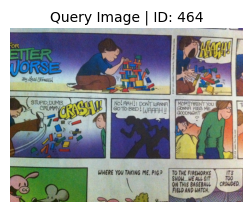

   Query Question: Is this picture better?

------------------------------ SEARCH RESULTS ------------------------------


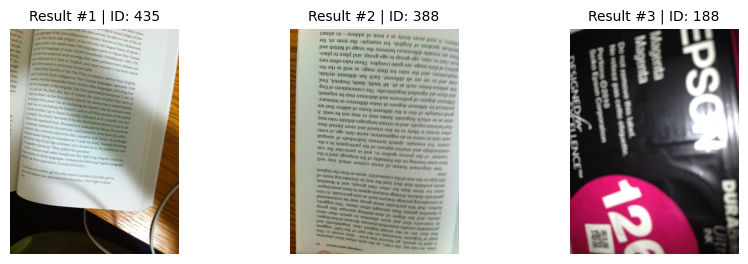

  Result #1 Details:
     Question: What page number is this? Thank you.
     Answerability: unanswerable
     Question Type: Reading
     Crowd Majority: unanswerable
     Distance: 0.8081

  Result #2 Details:
     Question: What page is this?  Thank you.
     Answerability: unanswerable
     Question Type: Reading
     Crowd Majority: unanswerable
     Distance: 0.8243

  Result #3 Details:
     Question: What color is this cartridge?
     Answerability: answerable
     Question Type: Description
     Crowd Majority: magenta
     Distance: 0.8277



In [31]:
import json
import random
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# --- Las mismas funciones de ayuda que definimos para el script de OpenCLIP ---
# Las incluimos aquí para que este script sea autocontenido.

def show_query_image(url, title=""):
    """Downloads and displays a single image with a smaller size."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.title(title, fontsize=10)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"--- Could not display image from {url}: {e} ---")

def show_results_horizontally(results_list):
    """
    Downloads and displays a list of result images in a single row (smaller),
    with metadata printed below each image.
    """
    num_results = len(results_list)
    if num_results == 0:
        return
    fig, axes = plt.subplots(1, num_results, figsize=(3 * num_results, 3))
    if num_results == 1:
        axes = [axes]

    print("\n" + "-"*30 + " SEARCH RESULTS " + "-"*30)
    for i, result_data in enumerate(results_list):
        metadata = result_data.get('metadata', {})
        result_id = result_data.get('id', 'N/A')
        image_url = metadata.get('image_url', '')
        ax = axes[i]
        
        if image_url:
            try:
                response = requests.get(image_url)
                response.raise_for_status()
                img = Image.open(BytesIO(response.content))
                ax.imshow(img)
            except Exception as e:
                ax.text(0.5, 0.5, f"Image not found:\n{e}", ha='center', va='center', fontsize=8)
        else:
            ax.text(0.5, 0.5, "No Image URL", ha='center', va='center', fontsize=8)

        ax.set_title(f"Result #{i+1} | ID: {result_id}", fontsize=10)
        ax.axis('off')

    plt.tight_layout(pad=2.0)
    plt.show()

    for i, result_data in enumerate(results_list):
        metadata = result_data.get('metadata', {})
        distance = result_data.get('distance', 0.0)
        # <<< CAMBIO: Se han añadido todos los campos de metadatos >>>
        print(f"  Result #{i+1} Details:")
        print(f"     Question: {metadata.get('question', 'N/A')}")
        print(f"     Answerability: {metadata.get('answerability', 'N/A')}")
        print(f"     Question Type: {metadata.get('question_type', 'N/A')}")
        print(f"     Crowd Majority: {metadata.get('crowd_majority', 'N/A')}")
        print(f"     Distance: {distance:.4f}\n")


# ==============================================================================
# Bloque Principal de Búsqueda Aleatoria de COHERE (Actualizado)
# ==============================================================================

print("\n" + "="*80)
print("🚀 Testing COHERE Similarity Search with a RANDOM query")
print("="*80)

# Asegúrate de que la variable 'db' esté apuntando a la base de datos de COHERE
# antes de ejecutar este bloque. Por ejemplo: db.use_collection("vizwiz_experiment_v1")

try:
    # Apunta al archivo de validación de COHERE
    validation_file = "./data/embeddings/lf_vqa_validation_embeddings_cohere.json"
    with open(validation_file, 'r') as f:
        validation_data = json.load(f)
    
    print(f"📁 Loaded COHERE validation file '{validation_file}' with {validation_data['count']} embeddings")
    
    # Selecciona un item de validación al azar
    random_validation_item = random.choice(validation_data['items'])
    query_embedding = random_validation_item['embedding'][0]
    query_metadata = random_validation_item['metadata']
    query_id = random_validation_item['id']
    
    # Muestra la imagen de consulta y su pregunta
    print(f"\n🎯 Selected random validation image for query:")
    query_image_url = query_metadata.get('image_url')
    show_query_image(query_image_url, title=f"Query Image | ID: {query_id}")
    print(f"   Query Question: {query_metadata.get('question', 'N/A')}")
    
    # Realiza la búsqueda
    results = db.search_similar_images(query_embedding, n_results=6)
    
    # Filtra el resultado si coincide con el ID de la consulta
    filtered_results = [res for res in results['similar_images'] if res.get('id') != query_id]
    final_results_to_display = filtered_results

    # Muestra los resultados con el ploteo horizontal
    if not final_results_to_display:
        print("\n   No other similar images were found in the database.")
    else:
        # <<< CAMBIO: Se llama a la nueva función de ploteo horizontal >>>
        show_results_horizontally(final_results_to_display)

except FileNotFoundError:
    print(f"❌ COHERE validation embeddings file not found: {validation_file}")
    print("Please make sure the Cohere validation embeddings have been generated first.")
except Exception as e:
    print(f"❌ An error occurred during the Cohere test: {e}")

## Define embedding generation functions

## Define embedding generation functions

# Precalculate Embeddings and Store

In [19]:
# Generate and save embeddings for validation images
import json
import os
from pathlib import Path

print("\n💾 Generating and saving validation embeddings to disk...")

# Create embeddings directory
os.makedirs("../data/embeddings", exist_ok=True)

# Prepare filename for validation embeddings
validation_filename = "./data/embeddings/lf_vqa_validation_embeddings.json"

# Generate and save validation embeddings
try:
    validation_embeddings = []
    
    print(f"Generating embeddings for {len(validation_sample)} validation images...")
    
    # Extract validation entries from all_data using validation_sample IDs
    for val_id in validation_sample:
        if val_id in all_data:  # Only check if ID exists in original data
            val_entry = all_data[val_id]
            image_url = val_entry.get('image_url', '')
            
            if image_url:
                # Generate embedding for this validation image using original data
                embedding = cohere_generate_image_embedding(image_url)
                
                validation_embeddings.append({
                    "id": val_id,
                    "embedding": embedding,
                    "metadata": {
                        "question": val_entry.get('question', ''),
                        "answerability": val_entry.get('answerability', ''),
                        "question_type": val_entry.get('question_type', ''),
                        "crowd_majority": val_entry.get('crowd_majority', ''),
                        "image_url": image_url
                    }
                })
                print(f"  Generated embedding for validation ID: {val_id} (from original data)")
            else:
                print(f"  ⚠️ No image URL found for validation ID: {val_id}")
        else:
            print(f"  ⚠️ Validation ID {val_id} not found in original data")
    
    # Save validation embeddings to file
    validation_data = {
        "count": len(validation_embeddings),
        "items": validation_embeddings,
    }
    
    with open(validation_filename, 'w') as f:
        json.dump(validation_data, f)
    
    print(f"✅ Saved {len(validation_embeddings)} validation embeddings to {validation_filename}")
    print(f"📊 Success rate: {len(validation_embeddings)}/{len(validation_sample)} validation images processed")
except Exception as e:
    print(f"❌ Error generating validation embeddings: {str(e)}")



💾 Generating and saving validation embeddings to disk...
Generating embeddings for 100 validation images...
  Generated embedding for validation ID: 396 (from original data)
  Generated embedding for validation ID: 60 (from original data)
  Generated embedding for validation ID: 519 (from original data)
  Generated embedding for validation ID: 77 (from original data)
  Generated embedding for validation ID: 391 (from original data)
  Generated embedding for validation ID: 583 (from original data)
  Generated embedding for validation ID: 41 (from original data)
  Generated embedding for validation ID: 453 (from original data)
  Generated embedding for validation ID: 35 (from original data)
  Generated embedding for validation ID: 464 (from original data)
  Generated embedding for validation ID: 61 (from original data)
  Generated embedding for validation ID: 305 (from original data)
  Generated embedding for validation ID: 74 (from original data)
  Generated embedding for validation ID

# Testing Query